# **EEG classification project**

# Introduction

- This project centers around a classification challenge involving Electroencephalography (EEG) time series data that captures different stages of the human sleep cycle.

- Our objective is to develop and evaluate robust classification models capable of accurately predicting sleep states—namely Wake, REM, and three stages of Non-REM (E1, E2, E3)—based solely on EEG signal recordings.

- The dataset provided consists of 5000 labeled training samples and 500 unlabeled test samples. In this notebook, we document our entire workflow—from data preprocessing and feature engineering to model selection, training, and final predictions—offering insights into the decisions made and results obtained.

# Necessary libraries installation and imports

In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0


In [ ]:
!pip install tsfresh

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from xgboost import XGBClassifier
import time
# Import tsfresh package and its utility functions
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from tsfresh.utilities.dataframe_functions import impute

import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

- This notebook contains our detailed approach to reach the best model we could find
- If you only want to make predictions on the test data you can directly run **Prediction on the test set** section
- A link to a drive containing the final prediction on the test set is provided as well

# 1. Loading dataset

- we load the data and split it into train and test to use afterwards

In [ ]:
def load_data(file_path):
        """
        Load the EEG time series data
        Each row is a sample with the first value as the class label
        """
        data = pd.read_csv(file_path, header=None)

        # Separate class labels and time series data
        y = data.iloc[:, 0].values
        X = data.iloc[:, 1:].values

        return X, y

def z_normalize(X):
    return (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

In [ ]:
X,y = load_data('Sleep Train 5000.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
X_train_norm = z_normalize(X_train)
X_test_norm = z_normalize(X_test)

- A differenced version of the data was also created to help stationarizing the data and improve classification accuracy.
- This will be used and compared with the results obtained from the original dataset

In [ ]:
# the first difference of the data
# Drop the first column (which is NaN after differencing)
X_diff = pd.DataFrame(X).diff(axis=1)
X_diff = X_diff.iloc[:,1:]

In [ ]:
X_train_diff, X_test_diff, y_train, y_test = train_test_split(X_diff, y, test_size=0.25, random_state=42, stratify=y)

# 2. Models on raw time series

- In this section we use some models that inherently handle the feature extraction step
- These models are to be applied on the raw time series data

## a. CNN ( djalil )

**CNN for Time Series:**


*   CNN (Convolutional Neural Network) is a deep learning model that can work on time series data.
It uses filters (like sliding windows) to detect patterns in the signal such as peaks, drops, or trends.
These filters move across the data and help the model learn what parts are important.
*   CNN works well with raw data and doesn’t need manual feature extraction.
It’s fast, powerful, and good at finding local patterns in the signal.



*   CNN on normalized data Time Series:
CNN is a type of deep learning model that can work directly on raw time series data.
It uses filters that slide over the sequence to detect patterns like spikes, trends, or repeated shapes.
This helps the model learn important parts of the signal automatically, without needing to extract features by hand.


*   CNN on Statistical Features:
Instead of using the raw signal, we can first calculate statistical features like mean, max, standard deviation, etc.
These features summarize the signal.
Then, we apply CNN on these features to learn useful combinations and patterns between them.

*   CNN on Statistical Features + PCA:
In this method, we first extract many features from the time series (like mean, peaks, energy, etc.).
Then we apply PCA to reduce the number of features.
This gives us a smaller set of strong features that we can use for training a model more efficiently.

*   CNN on First Difference + Statistical Features + PCA:
Here, we first take the first difference of the time series to focus on changes.
Then we extract statistical features from this differenced data.
After that, we apply PCA to reduce the number of features.
This method is useful when we care more about changes than raw values, and still want to keep meaningful statistics.



In [ ]:

print("Applying PCA on normalized data...")
pca_norm = PCA(n_components=0.95)
X_train_pca_norm = pca_norm.fit_transform(X_train_norm)
X_test_pca_norm = pca_norm.transform(X_test_norm)

print(f"Original data shape: {X_train_norm.shape}")
print(f"PCA transformed data shape: {X_train_pca_norm.shape}")
print(f"Number of components used: {pca_norm.n_components_}")
print(f"Explained variance ratio: {np.sum(pca_norm.explained_variance_ratio_):.4f}")


print("\nApplying PCA on differenced data...")
pca_diff = PCA(n_components=0.95)
X_train_pca_diff = pca_diff.fit_transform(X_train_diff)
X_test_pca_diff = pca_diff.transform(X_test_diff)

print(f"Original differenced data shape: {X_train_diff.shape}")
print(f"PCA transformed differenced data shape: {X_train_pca_diff.shape}")
print(f"Number of components used: {pca_diff.n_components_}")
print(f"Explained variance ratio: {np.sum(pca_diff.explained_variance_ratio_):.4f}")

Applying PCA on normalized data...
Original data shape: (3749, 178)
PCA transformed data shape: (3749, 81)
Number of components used: 81
Explained variance ratio: 0.9506

Applying PCA on differenced data...
Original differenced data shape: (3749, 177)
PCA transformed differenced data shape: (3749, 146)
Number of components used: 146
Explained variance ratio: 0.9515


In [ ]:
def extract_statistical_features(X, pca_features=None):
    """
    Extract statistical features from time series data and optionally combine with PCA features
    Args:
        X: Input time series data (n_samples, n_features)
        pca_features: Optional PCA features to combine with (n_samples, n_components)
    Returns:
        DataFrame containing combined features
    """
    if isinstance(X, pd.DataFrame):
        X = X.values

    # Initialize an empty array to store statistical features
    n_samples = X.shape[0]
    stat_features = np.zeros((n_samples, 6))

    # Calculate statistical features for each sample
    for i in range(n_samples):
        series = X[i, :]
        stat_features[i, 0] = np.mean(series)      # Mean
        stat_features[i, 1] = np.min(series)       # Min
        stat_features[i, 2] = np.max(series)       # Max
        stat_features[i, 3] = np.std(series)       # Standard deviation
        stat_features[i, 4] = np.sum(series**2)    # Energy
        stat_features[i, 5] = np.var(series)       # Variance

    # Create feature names
    stat_feature_names = ['mean', 'min', 'max', 'std', 'energy', 'variance']

    # If PCA features are provided, combine them
    if pca_features is not None:
        n_pca_components = pca_features.shape[1]
        pca_feature_names = [f'pca_{i}' for i in range(n_pca_components)]
        combined_features = np.concatenate([pca_features, stat_features], axis=1)
        combined_feature_names = pca_feature_names + stat_feature_names
        return pd.DataFrame(combined_features, columns=combined_feature_names)
    else:
        return pd.DataFrame(stat_features, columns=stat_feature_names)

In [ ]:
# Extract from normalized data
X_train_stat_norm = extract_statistical_features(X_train_norm,X_train_pca_norm)
X_test_stat_norm = extract_statistical_features(X_test_norm,X_test_pca_norm)

# Extract from differenced data
X_train_stat_diff = extract_statistical_features(X_train_diff,X_train_pca_diff)
X_test_stat_diff = extract_statistical_features(X_test_diff, X_test_pca_diff)

print(f"Statistical features shape: {X_train_stat_norm.shape}")

Statistical features shape: (3749, 87)


In [ ]:
#Prepare data for CNN models
# For original normalized data
X_train_cnn_norm = X_train_norm.reshape(X_train_norm.shape[0], X_train_norm.shape[1], 1)
X_test_cnn_norm = X_test_norm.reshape(X_test_norm.shape[0], X_test_norm.shape[1], 1)

# For PCA reduced normalized data
X_train_cnn_pca_norm = X_train_pca_norm.reshape(X_train_pca_norm.shape[0], X_train_pca_norm.shape[1], 1)
X_test_cnn_pca_norm = X_test_pca_norm.reshape(X_test_pca_norm.shape[0], X_test_pca_norm.shape[1], 1)

# For statistical features of normalized data
X_train_cnn_stat_norm = X_train_stat_norm.values.reshape(X_train_stat_norm.shape[0], X_train_stat_norm.shape[1], 1)
X_test_cnn_stat_norm = X_test_stat_norm.values.reshape(X_test_stat_norm.shape[0], X_test_stat_norm.shape[1], 1)



# For differenced data - convert to numpy if needed
if isinstance(X_train_diff, pd.DataFrame):
    X_train_diff_np = X_train_diff.values
    X_test_diff_np = X_test_diff.values
else:
    X_train_diff_np = X_train_diff
    X_test_diff_np = X_test_diff

X_train_cnn_diff = X_train_diff_np.reshape(X_train_diff_np.shape[0], X_train_diff_np.shape[1], 1)
X_test_cnn_diff = X_test_diff_np.reshape(X_test_diff_np.shape[0], X_test_diff_np.shape[1], 1)

# For PCA reduced differenced data
X_train_cnn_pca_diff = X_train_pca_diff.reshape(X_train_pca_diff.shape[0], X_train_pca_diff.shape[1], 1)
X_test_cnn_pca_diff = X_test_pca_diff.reshape(X_test_pca_diff.shape[0], X_test_pca_diff.shape[1], 1)

# For statistical features of differenced data
X_train_cnn_stat_diff = X_train_stat_diff.values.reshape(X_train_stat_diff.shape[0], X_train_stat_diff.shape[1], 1)
X_test_cnn_stat_diff = X_test_stat_diff.values.reshape(X_test_stat_diff.shape[0], X_test_stat_diff.shape[1], 1)

# Convert class labels to categorical format
# Count unique classes
n_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train-1, num_classes=n_classes)  # Subtract 1 if classes start from 1
y_test_cat = to_categorical(y_test-1, num_classes=n_classes)    # Subtract 1 if classes start from 1

In [ ]:
#Build CNN models
def create_cnn_model(input_shape, n_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Train and evaluate models
def train_and_evaluate(X_train, X_test, y_train_cat, y_test_cat, model_name):
    print(f"\nTraining CNN model for {model_name}...")
    input_shape = (X_train.shape[1], 1)
    model = create_cnn_model(input_shape, n_classes)

    history = model.fit(
        X_train, y_train_cat,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"{model_name} Test accuracy: {accuracy:.4f}")

    # Make predictions and calculate metrics
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model, history


Training CNN model for Normalized Raw Data...
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.3850 - loss: 1.4672 - val_accuracy: 0.4933 - val_loss: 1.2253
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4592 - loss: 1.2487 - val_accuracy: 0.4787 - val_loss: 1.2042
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4905 - loss: 1.2079 - val_accuracy: 0.5000 - val_loss: 1.1750
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5143 - loss: 1.1720 - val_accuracy: 0.4987 - val_loss: 1.1469
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5221 - loss: 1.1354 - val_accuracy: 0.5200 - val_loss: 1.1123
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5401 - loss: 1.0880 - val_accuracy: 0.5147 - val_loss: 1.1003
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5549 - loss: 1.0577 - val_accuracy: 0.5413 - val_loss: 1.0756
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - acc

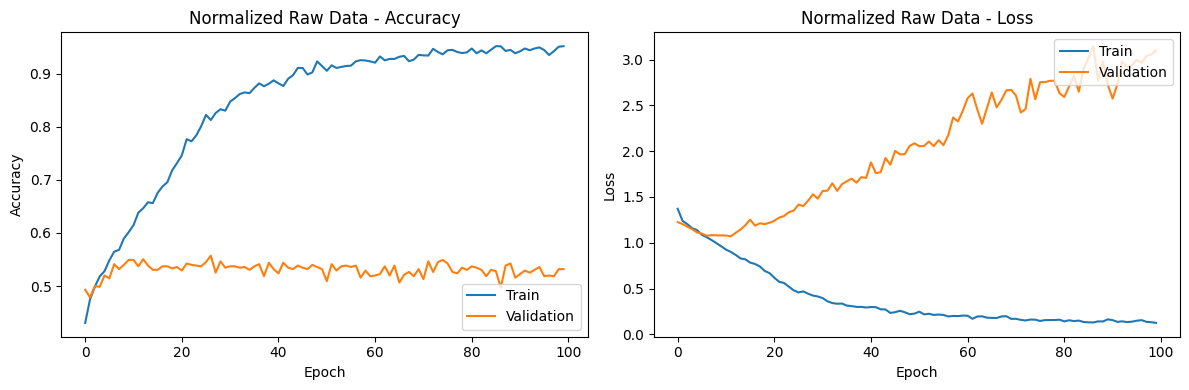

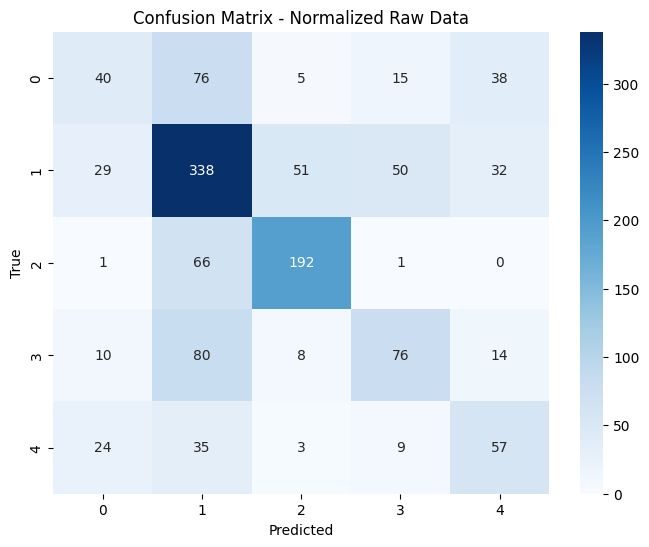


Training CNN model for PCA Normalized Data...
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4038 - loss: 1.4112 - val_accuracy: 0.5280 - val_loss: 1.1284
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5014 - loss: 1.1726 - val_accuracy: 0.5493 - val_loss: 1.0785
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5127 - loss: 1.1156 - val_accuracy: 0.5480 - val_loss: 1.0354
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5316 - loss: 1.1112 - val_accuracy: 0.5600 - val_loss: 1.0132
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5591 - loss: 1.0545 - val_accuracy: 0.5760 - val_loss: 1.0068
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5691 - loss: 1.0232 - val_accuracy: 0.5733 - val_loss: 1.0004
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5844 - loss: 1.0228 - val_accuracy: 0.5760 - val_loss: 0.9885
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc

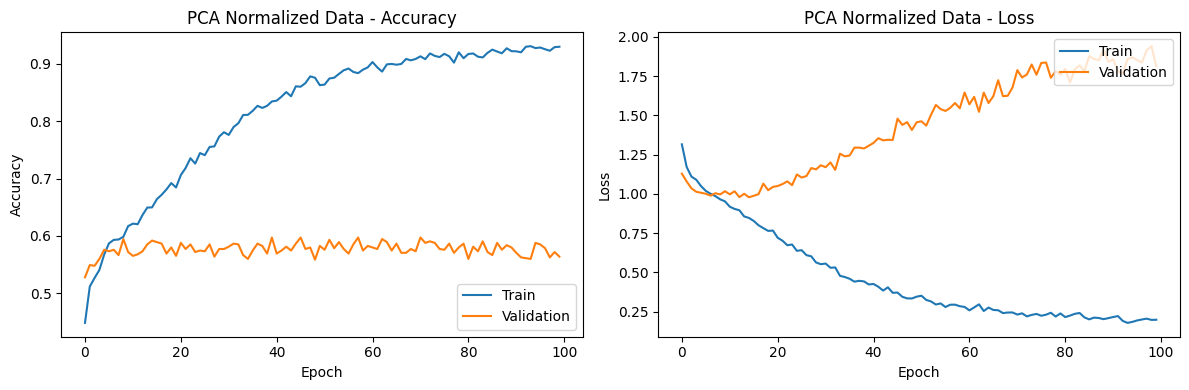

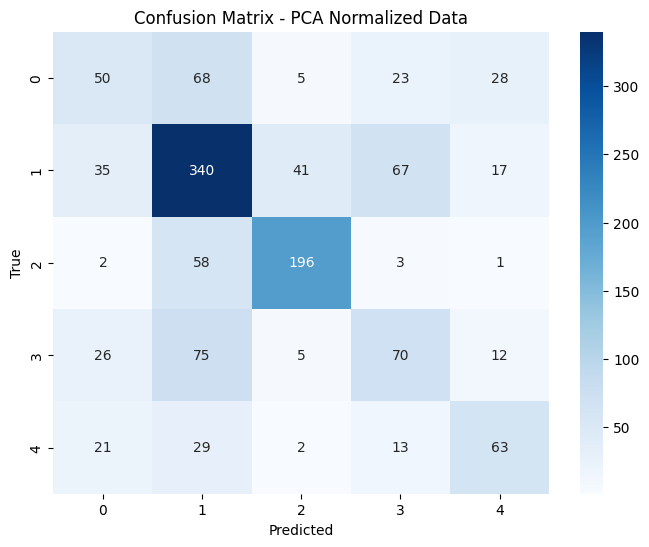


Training CNN model for Statistical Features - Normalized Data...
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3318 - loss: 1.6756 - val_accuracy: 0.5213 - val_loss: 1.1813
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4641 - loss: 1.2717 - val_accuracy: 0.5453 - val_loss: 1.1073
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4965 - loss: 1.1873 - val_accuracy: 0.5507 - val_loss: 1.0559
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5127 - loss: 1.1535 - val_accuracy: 0.5507 - val_loss: 1.0220
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5327 - loss: 1.1160 - val_accuracy: 0.5573 - val_loss: 1.0327
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5467 - loss: 1.0947 - val_accuracy: 0.5547 - val_loss: 1.0180
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5687 - loss: 1.0584 - val_accuracy: 0.5667 - val_loss: 1.0027
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━

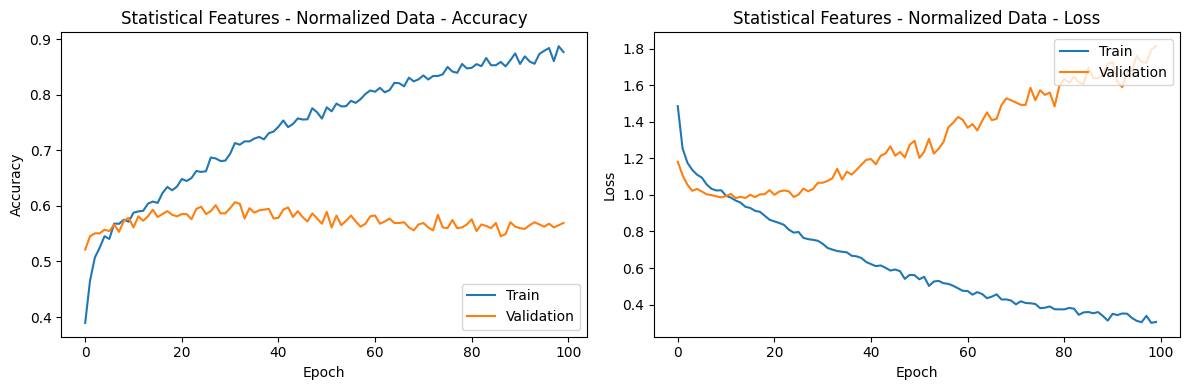

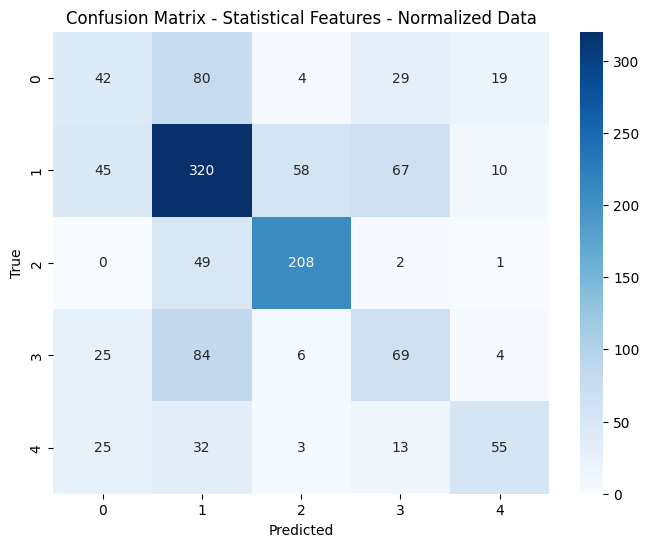


Training CNN model for Differenced Data...
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.3155 - loss: 2.1850 - val_accuracy: 0.4080 - val_loss: 1.3503
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3913 - loss: 1.3412 - val_accuracy: 0.4627 - val_loss: 1.2690
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4483 - loss: 1.2617 - val_accuracy: 0.4920 - val_loss: 1.2015
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4721 - loss: 1.2042 - val_accuracy: 0.4773 - val_loss: 1.1655
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5061 - loss: 1.1471 - val_accuracy: 0.5080 - val_loss: 1.1484
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4944 - loss: 1.1389 - val_accuracy: 0.5093 - val_loss: 1.1162
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5424 - loss: 1.0495 - val_accuracy: 0.5147 - val_loss: 1.1167
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accura

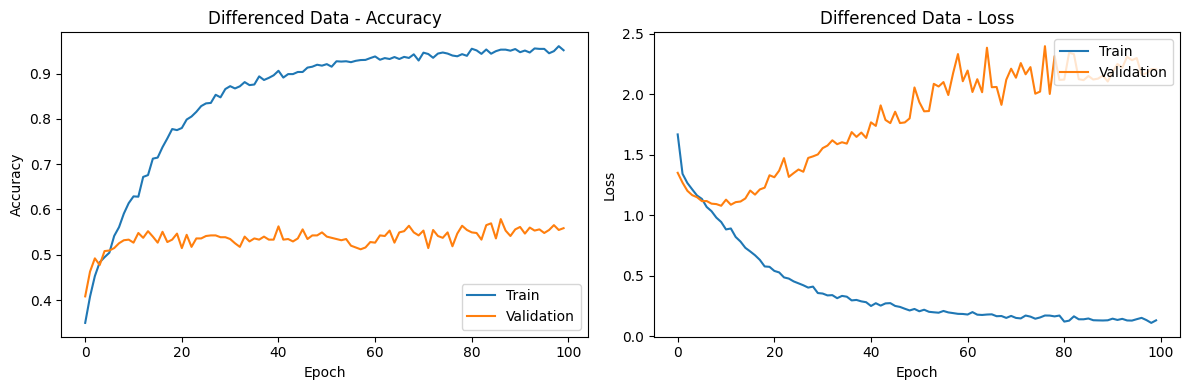

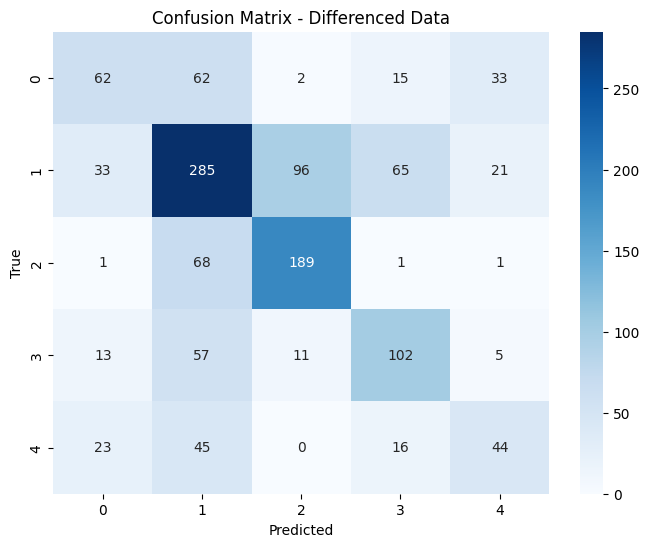


Training CNN model for PCA Differenced Data...
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3119 - loss: 2.0056 - val_accuracy: 0.4013 - val_loss: 1.4884
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3851 - loss: 1.4773 - val_accuracy: 0.4040 - val_loss: 1.4691
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.3979 - loss: 1.4342 - val_accuracy: 0.3920 - val_loss: 1.4522
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4070 - loss: 1.4256 - val_accuracy: 0.3907 - val_loss: 1.3995
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4093 - loss: 1.3960 - val_accuracy: 0.3907 - val_loss: 1.3919
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4127 - loss: 1.3598 - val_accuracy: 0.3920 - val_loss: 1.3668
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4236 - loss: 1.3526 - val_accuracy: 0.3933 - val_loss: 1.3488
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - ac

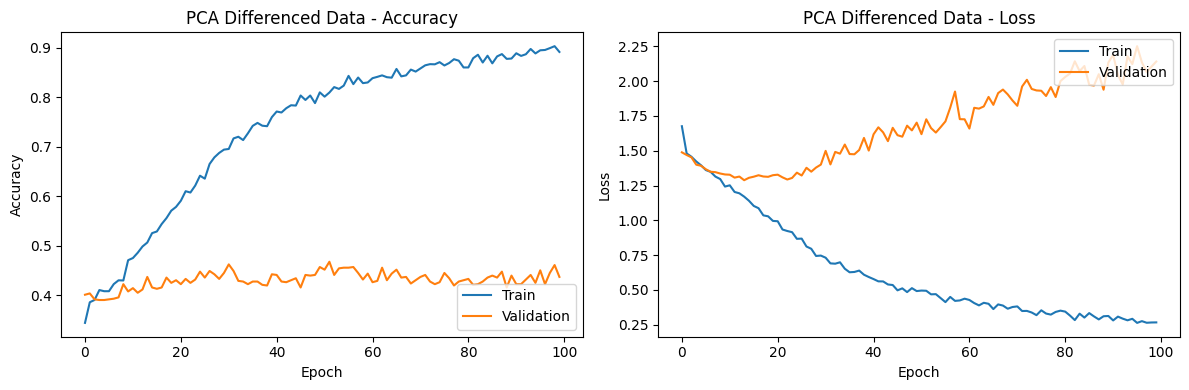

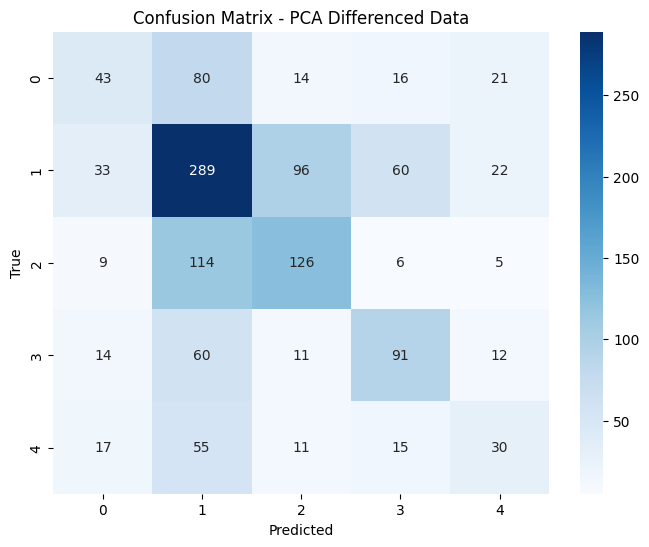


Training CNN model for Statistical Features - Differenced Data...
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.3098 - loss: 2.0411 - val_accuracy: 0.4013 - val_loss: 1.5262
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.3760 - loss: 1.4685 - val_accuracy: 0.3947 - val_loss: 1.4841
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3906 - loss: 1.4484 - val_accuracy: 0.3920 - val_loss: 1.4169
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4028 - loss: 1.4136 - val_accuracy: 0.4000 - val_loss: 1.4129
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3966 - loss: 1.3724 - val_accuracy: 0.4280 - val_loss: 1.3871
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4333 - loss: 1.3532 - val_accuracy: 0.4027 - val_loss: 1.3725
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4134 - loss: 1.3390 - val_accuracy: 0.4040 - val_loss: 1.3537
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━

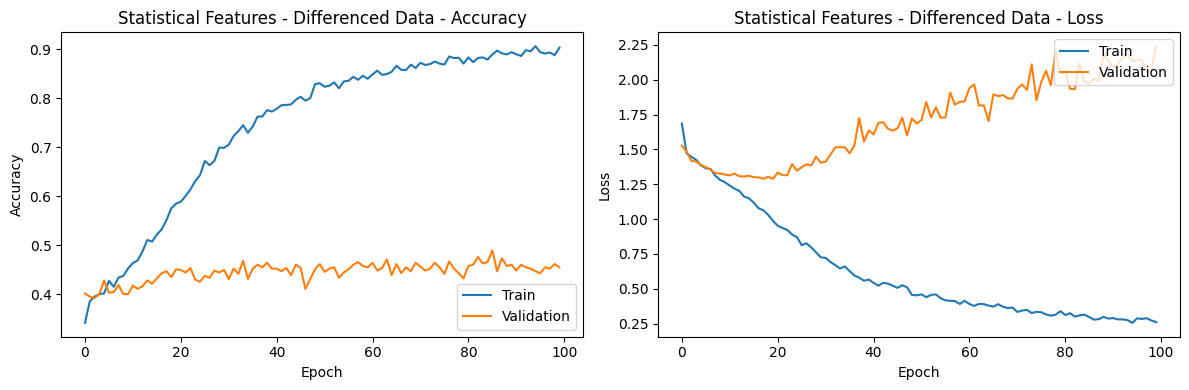

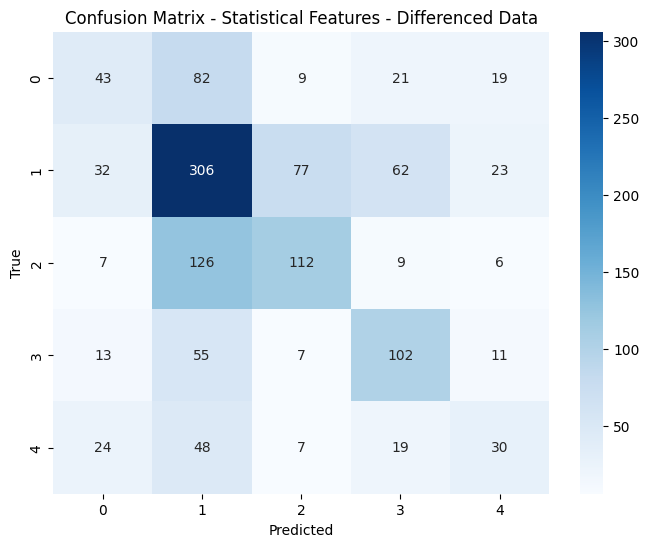

In [ ]:
# Model training and evaluation for each dataset
# Train on normalized data
model_norm, history_norm = train_and_evaluate(
    X_train_cnn_norm, X_test_cnn_norm,
    y_train_cat, y_test_cat,
    "Normalized Raw Data"
)

# Train on PCA-reduced normalized data
model_pca_norm, history_pca_norm = train_and_evaluate(
    X_train_cnn_pca_norm, X_test_cnn_pca_norm,
    y_train_cat, y_test_cat,
    "PCA Normalized Data"
)

# Train on statistical features from normalized data
model_stat_norm, history_stat_norm = train_and_evaluate(
    X_train_cnn_stat_norm, X_test_cnn_stat_norm,
    y_train_cat, y_test_cat,
    "Statistical Features - Normalized Data"
)

# Train on differenced data
model_diff, history_diff = train_and_evaluate(
    X_train_cnn_diff, X_test_cnn_diff,
    y_train_cat, y_test_cat,
    "Differenced Data"
)

# Train on PCA-reduced differenced data
model_pca_diff, history_pca_diff = train_and_evaluate(
    X_train_cnn_pca_diff, X_test_cnn_pca_diff,
    y_train_cat, y_test_cat,
    "PCA Differenced Data"
)

# Train on statistical features from differenced data
model_stat_diff, history_stat_diff = train_and_evaluate(
    X_train_cnn_stat_diff, X_test_cnn_stat_diff,
    y_train_cat, y_test_cat,
    "Statistical Features - Differenced Data"
)

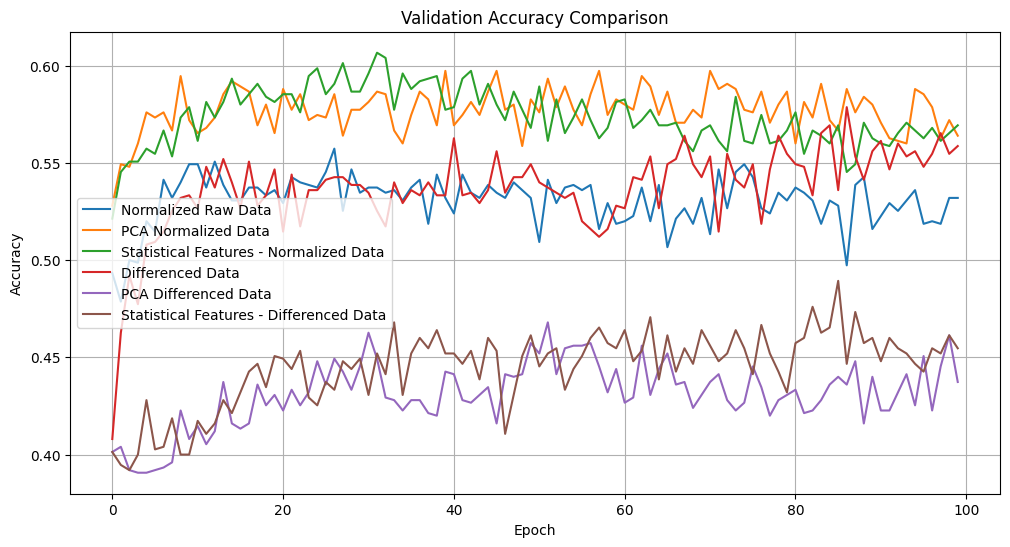

In [ ]:
# Compare all models
models = [
    "Normalized Raw Data",
    "PCA Normalized Data",
    "Statistical Features - Normalized Data",
    "Differenced Data",
    "PCA Differenced Data",
    "Statistical Features - Differenced Data"
]

histories = [
    history_norm,
    history_pca_norm,
    history_stat_norm,
    history_diff,
    history_pca_diff,
    history_stat_diff
]

# Plot validation accuracy comparison
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['val_accuracy'], label=models[i])

plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Summary of model performances
print("\nModel Performance Summary:")
for i, model_name in enumerate(models):
    final_val_acc = histories[i].history['val_accuracy'][-1]
    print(f"{model_name}: Validation Accuracy = {final_val_acc:.4f}")


Model Performance Summary:
Normalized Raw Data: Validation Accuracy = 0.5320
PCA Normalized Data: Validation Accuracy = 0.5640
Statistical Features - Normalized Data: Validation Accuracy = 0.5693
Differenced Data: Validation Accuracy = 0.5587
PCA Differenced Data: Validation Accuracy = 0.4373
Statistical Features - Differenced Data: Validation Accuracy = 0.4547


## b. Rocket classifier

- The ROCKETClassifier is a fast and powerful method for time series classification that transforms raw signals into useful features using random filters. These filters act as pattern detectors that scan the time series to identify important shapes or signal patterns.
- ROCKET applies thousands of randomly generated filters (small sliding windows) to the time series. Each filter is like a pattern detector that looks for specific local behaviors in the signal, such as:
  - Sudden spikes
  - Gradual increases or decreases
  - Repeated oscillations

- Each filter is convolved with the time series — this means the filter slides along the data, multiplying and summing values at each step. The result is a new series that shows how well the pattern matches at different points in time
- This way **RocketClassifier** captures complex temporal patterns that are relevant for different mental states or activities
- The resulting feature set is used to train a fast linear classifier like SVM or random forest

In [ ]:
def to_nested_dataframe(X):
    """Convert 2D NumPy array (n_samples, n_timesteps) to sktime's nested format."""
    return pd.DataFrame({0: [pd.Series(row) for row in X]})

In [ ]:
def train_rocket_classifier(X_train, y_train):
    X_train_nested = to_nested_dataframe(X_train)
    rocket = RocketClassifier(random_state=42)
    rocket.fit(X_train_nested, y_train)
    return rocket

def evaluate_rocket(rocket, X_test, y_test):
    X_test_nested = to_nested_dataframe(X_test)
    y_pred = rocket.predict(X_test_nested)
    return accuracy_score(y_test, y_pred)

In [ ]:
# running the model on the raw data
rocket = train_rocket_classifier(X_train, y_train)
accuracy = evaluate_rocket(rocket, X_test, y_test)
print(f"Rocket Accuracy: {accuracy:.4f}")

Rocket Accuracy: 0.6232


In [ ]:
# running the model after normalizing the data
rocket = train_rocket_classifier(X_train_norm, y_train)
accuracy = evaluate_rocket(rocket, X_test_norm, y_test)
print(f"Rocket Accuracy: {accuracy:.4f}")

Rocket Accuracy: 0.6232


- we can see that running the model on the raw data or the normalized raw data gives the same results
- an accuracy of 62.32 is a bit low and indicates the model is not capturing well the variance in our data
- other approaches that involve feature extraction may be considered to increase the accuracy

## c. Supervised Time Series


- The Supervised Time Series Forest (STSF) is an ensemble-based classification algorithm specifically designed for time series data. It extends the idea of traditional random forests to time series by extracting informative summary statistics from sliding windows over the input sequences
- Instead of using raw values, STSF computes statistical features (e.g., mean, standard deviation) from sliding windows over the time dimension.
- It builds multiple decision trees on different feature representations, increasing robustness and generalization.
- This way it handles temporal dependencies effectively while maintaining high classification performance

In [ ]:
def convert_to_multiindex(df):
    n_instances, n_columns = df.shape
    timepoints = n_columns
    # Create a multi-index DataFrame
    arrays = [np.repeat(df.index, timepoints), np.tile(np.arange(timepoints), n_instances)]
    index = pd.MultiIndex.from_arrays(arrays, names=['instance', 'time'])
    df_multiindex = pd.DataFrame(df.values.flatten(), index=index)
    return df_multiindex

# Convert data to sktime format
X_train_sktime = convert_to_multiindex(pd.DataFrame(X_train))
X_test_sktime = convert_to_multiindex(pd.DataFrame(X_test))

X_diff_train_sktime = convert_to_multiindex(pd.DataFrame(X_train_diff))
X_diff_test_sktime = convert_to_multiindex(pd.DataFrame(X_test_diff))

In [ ]:
stsf = SupervisedTimeSeriesForest(n_estimators=50, random_state=47)
stsf.fit(X_train_sktime, y_train)

# Make predictions
y_train_pred_stsf = stsf.predict(X_train_sktime)
y_test_pred_stsf = stsf.predict(X_test_sktime)
# Evaluate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_stsf)
test_accuracy = accuracy_score(y_test, y_test_pred_stsf)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Testing Accuracy: 0.7032


- Using the raw EEG signals, the model reached 100% accuracy on the training set but only 70.32% on the test set. This gap suggests overfitting—while the model learned the training data well, it didn’t generalize as effectively to new data.

In [ ]:
stsf = SupervisedTimeSeriesForest(n_estimators=50, random_state=47)
stsf.fit(X_diff_train_sktime, y_train)

# Make predictions
y_train_pred_stsf = stsf.predict(X_diff_train_sktime)
y_test_pred_stsf = stsf.predict(X_diff_test_sktime)
# Evaluate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_stsf)
test_accuracy = accuracy_score(y_test, y_test_pred_stsf)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9997
Testing Accuracy: 0.7240


- After differencing the EEG data, test accuracy improved to 72.4%. This small boost shows that emphasizing changes in the signal helped the model capture more useful patterns for classification.
- This indicates that more data preprocessing can greatly increase the performance

# 3. Fourier transform

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score ,classification_report
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
sleep_train = pd.read_csv("./Sleep Train 5000.csv" , header= None)

In [ ]:
sleep_train.head()

,0,1,2,3,4,5,6,7,8,9,...,169,170,171,172,173,174,175,176,177,178
0,0,-1.608303,-13.170696,-8.997802,1.347497,5.259585,-1.521367,2.651526,4.651038,3.781685,...,-8.041514,-6.563614,-4.998779,-5.346520,-6.389744,-11.171185,-2.390720,1.086691,6.911355,6.128938
1,0,-2.825397,2.390720,3.955555,-4.216361,2.477656,2.129914,3.955555,-5.172649,5.694261,...,4.129426,7.085226,-2.390720,-2.303785,-3.694750,4.564103,-6.215873,-2.738462,-4.477167,-4.390232
2,0,-15.952625,-3.347008,-15.517949,-9.432479,-16.474237,-6.650549,-14.909402,-12.214408,-10.823443,...,-4.390232,-0.738950,4.477167,12.996825,21.951160,21.081806,21.603418,14.909402,9.345543,6.998291
3,0,-26.558731,-18.560684,-12.040537,-4.216361,-9.432479,1.260562,-2.216850,-3.520879,-5.781197,...,-3.086203,-0.652015,3.607814,15.170208,16.039560,6.128938,3.955555,-1.956044,-2.390720,-4.651038
4,0,-5.607326,6.042003,-4.129426,-5.172649,-7.172161,-11.953602,-7.780708,-0.130403,-2.912332,...,-1.260562,1.608303,4.564103,-4.911844,10.301831,10.127961,8.389256,-2.216850,-4.390232,0.478144


#### remark : <br>
in this section of the notebook , we will try to perform some adjustment on the data from renaming the columns

In [ ]:
num_features = sleep_train.shape[1] - 1
sleep_train.columns = ['target'] +[f'EEG_{i}' for i in range(num_features)]
sleep_train.shape

(4999, 179)

In [ ]:
sleep_train.head()

,target,EEG_0,EEG_1,EEG_2,EEG_3,EEG_4,EEG_5,EEG_6,EEG_7,EEG_8,...,EEG_168,EEG_169,EEG_170,EEG_171,EEG_172,EEG_173,EEG_174,EEG_175,EEG_176,EEG_177
0,0,-1.608303,-13.170696,-8.997802,1.347497,5.259585,-1.521367,2.651526,4.651038,3.781685,...,-8.041514,-6.563614,-4.998779,-5.346520,-6.389744,-11.171185,-2.390720,1.086691,6.911355,6.128938
1,0,-2.825397,2.390720,3.955555,-4.216361,2.477656,2.129914,3.955555,-5.172649,5.694261,...,4.129426,7.085226,-2.390720,-2.303785,-3.694750,4.564103,-6.215873,-2.738462,-4.477167,-4.390232
2,0,-15.952625,-3.347008,-15.517949,-9.432479,-16.474237,-6.650549,-14.909402,-12.214408,-10.823443,...,-4.390232,-0.738950,4.477167,12.996825,21.951160,21.081806,21.603418,14.909402,9.345543,6.998291
3,0,-26.558731,-18.560684,-12.040537,-4.216361,-9.432479,1.260562,-2.216850,-3.520879,-5.781197,...,-3.086203,-0.652015,3.607814,15.170208,16.039560,6.128938,3.955555,-1.956044,-2.390720,-4.651038
4,0,-5.607326,6.042003,-4.129426,-5.172649,-7.172161,-11.953602,-7.780708,-0.130403,-2.912332,...,-1.260562,1.608303,4.564103,-4.911844,10.301831,10.127961,8.389256,-2.216850,-4.390232,0.478144


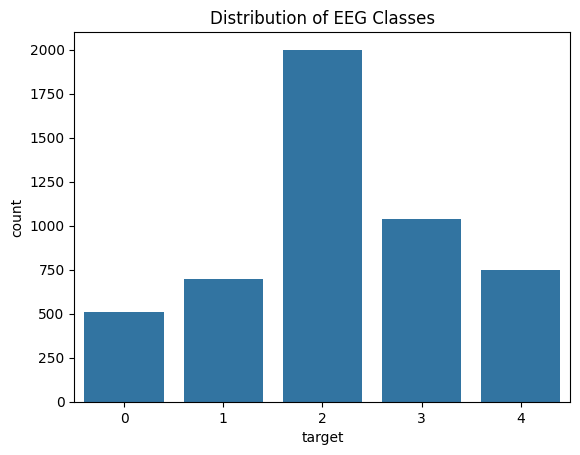

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=sleep_train)
plt.title('Distribution of EEG Classes')
plt.show()

#### Domain Knowledge : <br>
&nbsp;&nbsp;&nbsp;&nbsp; For the domain knowlege , we have consulted some features that have studied the different brain waves and what frequencies they are at , and the brain activity they represent and how they are related, this domain knowledge along with what we have seen in the dataset has influenced our feature extraction.<br>
[brain waves article](https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/brain-waves) <br>
&nbsp;&nbsp;&nbsp;&nbsp; For the data , from the insight that we got , we can clearly see that the distribution of the target is not even. this could include that we need to apply smooting to fix this distribution. we have also that each row is a real time series a recording of the brain waves with the target assigned with that recording. <br>

### Feature Extractions : <br>
****
<br>
&nbsp;&nbsp;&nbsp;&nbsp; Influenced by the data and the articles read above we will try to apply some feature extraction followed by feature selection. <br>

1. **Feature extraction**: <br>
&nbsp;&nbsp;&nbsp;&nbsp;for the feature extraction, we will apply spectral analysis to find the frequencies and using domain knowledge we will assign them to certain brain waves so that they could represent a valuable insight on the data. <br>
2. **Feature Selection** :<br>
&nbsp;&nbsp;&nbsp;&nbsp; For the feature selection , after getting insight on the data using spectral analysis we will add them to the attributes and run the algorithm on them and then we will apply feature selection by only running the model on the feature obtained from the spectral analysis.<br>    



In [ ]:
def compute_fft_features(eeg_signal, fs=128):
    # eeg_signal: 1D array of EEG (single sample)
    N = len(eeg_signal)
    freqs = fftfreq(N, 1/fs)
    fft_vals = np.abs(fft(eeg_signal))

    # Only keep positive frequencies
    freqs = freqs[:N//2]
    fft_vals = fft_vals[:N//2]

    # Define band powers
    def band_power(freqs, fft_vals, f_low, f_high):
        idx = np.logical_and(freqs >= f_low, freqs <= f_high)
        return np.mean(fft_vals[idx])

    return [
        band_power(freqs, fft_vals, 0.5, 4),   # Delta
        band_power(freqs, fft_vals, 4, 8),     # Theta
        band_power(freqs, fft_vals, 8, 13),    # Alpha
        band_power(freqs, fft_vals, 13, 30),   # Beta
        band_power(freqs, fft_vals, 30, 100)   # Gamma
    ]

In [ ]:
fft_features = sleep_train.drop(columns='target').apply(lambda row: compute_fft_features(row.values), axis=1, result_type='expand')
fft_features.columns = ['delta', 'theta', 'alpha', 'beta', 'gamma']
sleep_train_fft = pd.concat([sleep_train, fft_features], axis=1)

In [ ]:
X = sleep_train.drop(columns='target')
y = sleep_train['target']

In [ ]:
from sklearn.model_selection import GridSearchCV
def Apply_SVM(data):
  X= data.drop(columns='target')
  y= data['target']
  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
  )
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
  svm_model.fit(X_train_scaled, y_train)
  y_pred = svm_model.predict(X_test_scaled)

  print("Accuracy:", accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))
def apply_grid_search(data):
  X= data.drop(columns='target')
  y= data['target']
  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
  )
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
  }

  grid = GridSearchCV(SVC(), param_grid, cv=5)
  grid.fit(X_train_scaled, y_train)

  print("Best parameters:", grid.best_params_)
  print("Best cross-val score:", grid.best_score_)

In [ ]:
# without
Apply_SVM(sleep_train)
apply_grid_search(sleep_train)

 

Accuracy: 0.535
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       102
           1       0.17      0.01      0.01       140
           2       0.52      0.79      0.62       400
           3       0.70      0.79      0.74       208
           4       0.37      0.35      0.36       150

    accuracy                           0.54      1000
   macro avg       0.35      0.39      0.35      1000
weighted avg       0.43      0.54      0.46      1000



In [ ]:
# with
Apply_SVM(sleep_train_fft)
apply_grid_search(sleep_train_fft)

 
Accuracy: 0.596
              precision    recall  f1-score   support

           0       0.71      0.28      0.41       102
           1       0.35      0.04      0.08       140
           2       0.58      0.76      0.66       400
           3       0.72      0.80      0.76       208
           4       0.49      0.61      0.54       150

    accuracy                           0.60      1000
   macro avg       0.57      0.50      0.49      1000
weighted avg       0.58      0.60      0.55      1000




### Only Extracted Features : <br>
In this sections we will apply SVM only on the extracted features and we mean by that the brain waves and we will try to classify based on it.

In [ ]:
fft_features = sleep_train.drop(columns='target').apply(lambda row: compute_fft_features(row.values), axis=1, result_type='expand')
fft_features.columns = ['delta', 'theta', 'alpha', 'beta', 'gamma']
sleep_train_fft_only = pd.concat([ fft_features ,sleep_train['target']], axis=1)

In [ ]:
Apply_SVM(sleep_train_fft_only)
apply_grid_search(sleep_train_fft_only)


Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.60      0.54      0.57       102
           1       0.38      0.17      0.24       140
           2       0.63      0.77      0.69       400
           3       0.77      0.78      0.77       208
           4       0.64      0.61      0.63       150

    accuracy                           0.64      1000
   macro avg       0.60      0.57      0.58      1000
weighted avg       0.62      0.64      0.62      1000

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-val score: 0.6311555068836044



# 4. Wavelet transform

In [ ]:
!pip install PyWavelets


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def train_evaluate_xgboost(data, target_col='target', test_size=0.2, random_state=42):
    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Initialize XGBoost classifier
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", class_report)

    return model, {'accuracy': accuracy, 'classification_report': class_report}


In [ ]:
import pywt

def compute_wavelet_features(eeg_signal, wavelet='db4', level=5):
    """
    Compute wavelet features from a 1D EEG signal.

    Parameters:
    - eeg_signal: numpy array (1D), the EEG time series
    - wavelet: string, wavelet type (e.g. 'db4', 'haar', etc.)
    - level: int, number of decomposition levels

    Returns:
    - features: list of energies in each detail coefficient (level 1 to level N) plus approximation energy
    """
    # Perform discrete wavelet transform
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)

    # Calculate energy of each coefficient set (approximation + details)
    energies = [np.sum(np.square(c)) for c in coeffs]

    return energies

In [ ]:
wavelet_features = sleep_train.drop(columns='target').apply(
    lambda row: compute_wavelet_features(row.values), axis=1, result_type='expand'
)

# Name columns based on level; approx is cA, details cD1..cD5 (assuming level=5)
wavelet_features.columns = ['cA'] + [f'cD{level}' for level in range(1, 6)]

sleep_train_wavelet = pd.concat([wavelet_features, sleep_train['target']], axis=1)


/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [ ]:
Apply_SVM(sleep_train_wavelet)

Accuracy: 0.597
              precision    recall  f1-score   support

           0       0.65      0.38      0.48       102
           1       0.71      0.17      0.28       140
           2       0.58      0.71      0.64       400
           3       0.71      0.70      0.71       208
           4       0.49      0.69      0.57       150

    accuracy                           0.60      1000
   macro avg       0.63      0.53      0.54      1000
weighted avg       0.62      0.60      0.58      1000



In [ ]:
train_evaluate_xgboost(sleep_train_wavelet)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:37:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6390
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64       102
           1       0.57      0.30      0.39       140
           2       0.63      0.70      0.66       400
           3       0.71      0.76      0.74       208
           4       0.58      0.63      0.61       150

    accuracy                           0.64      1000
   macro avg       0.63      0.60      0.61      1000
weighted avg       0.63      0.64      0.63      1000



(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=100,
               n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...),
 {'accuracy': 0.639,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.65      0.63      0.64       102\n           1       0.57      0.30      0.39       140\n     

# 5. tsfresh features

**tsfresh** (Time Series Feature Extraction based on Scalable Hypothesis tests) is a powerful tool that automatically extracts a wide variety of statistical features from time series data. It generates hundreds of features per signal, covering different categories such as:

- **Statistical moments**: mean, variance, skewness, and kurtosis.

- **Frequency domain features**: FFT coefficients, spectral entropy.

- **Autocorrelation-based features**: autocorrelation values at various lags, partial autocorrelation.

- **Shape-based features**: number of peaks, average time between peaks, change quantiles.

- **Value distribution**: longest streaks above/below mean, value ranges, percentiles.

- **Wavelet-based features**: coefficients extracted at multiple time-frequency resolutions, capturing transient and localized patterns in non-stationary signals.

These features provide a comprehensive summary of the signal's shape, behavior, and variability, helping classifiers distinguish between classes more effectively

## feature extraction

In [ ]:
class TSFreshPreprocessor(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible preprocessor that extracts time series features
    using tsfresh and prepares data for machine learning models.

    Parameters:
    -----------
    feature_set: str, default='efficient'
        Which feature set to use: 'minimal', 'efficient', or 'comprehensive'

    standardize: bool, default=True
        Whether to standardize the features

    feature_selection: bool, default=True
        Whether to perform feature selection during fit

    n_jobs: int, default=0
        Number of jobs to run in parallel. 0 means using all processors.

    random_state: int, default=42
        Random state for reproducibility
    """

    def __init__(self, feature_set='efficient', standardize=True,
                 feature_selection=True, n_jobs=0, random_state=42):
        self.feature_set = feature_set
        self.standardize = standardize
        self.feature_selection = feature_selection
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.scaler = None
        self.selected_features = None
        np.random.seed(self.random_state)

    def _prepare_data_for_tsfresh(self, X):
        """
        Prepare data in the format required by tsfresh:
        | id | time | value |
        """
        # Create an empty DataFrame to store the transformed data
        df_tsfresh = pd.DataFrame(columns=['id', 'time', 'value'])

        # Convert each time series into the required format
        for i in range(len(X)):
            time_series = X[i]
            time_points = np.arange(len(time_series))

            # Create a DataFrame for this specific time series
            temp_df = pd.DataFrame({
                'id': i,
                'time': time_points,
                'value': time_series
            })

            # Append to the main DataFrame
            df_tsfresh = pd.concat([df_tsfresh, temp_df], ignore_index=True)

        return df_tsfresh

    def _get_extraction_settings(self):
        """Get the appropriate feature calculation settings"""
        if self.feature_set == 'minimal':
            return MinimalFCParameters()
        elif self.feature_set == 'comprehensive':
            return None  # Default is comprehensive
        else:  # 'efficient' is the default
            return EfficientFCParameters()

    def fit(self, X, y=None):
        """
        Extract features from time series data and optionally perform feature selection.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_time_points)
            Time series data

        y : array-like of shape (n_samples,), optional
            Target values for supervised feature selection

        Returns:
        --------
        self : object
            Returns self
        """
        # Prepare data for tsfresh
        df_tsfresh = self._prepare_data_for_tsfresh(X)

        # Extract features
        extraction_settings = self._get_extraction_settings()
        features_df = extract_features(df_tsfresh,
                                      column_id='id',
                                      column_sort='time',
                                      column_value='value',
                                      default_fc_parameters=extraction_settings,
                                      n_jobs=self.n_jobs)

        # Impute any NaN values
        impute(features_df)

        # If y is provided and feature_selection is True, select relevant features
        if self.feature_selection and y is not None:
            # Create a mapping from time series ID to class label
            y_dict = {i: y[i] for i in range(len(y))}

            # Map the time series IDs in features_df to their corresponding class labels
            y_mapped = pd.Series([y_dict[i] for i in features_df.index])

            # Select features that are relevant for classification
            features_df = select_features(features_df, y_mapped)

        # Store the selected feature names for transform
        self.selected_features = features_df.columns.tolist()

        # If standardization is enabled, fit the scaler
        if self.standardize:
            self.scaler = StandardScaler()
            self.scaler.fit(features_df)

        return self

    def transform(self, X):
        """
        Transform time series data into extracted features.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_time_points)
            Time series data

        Returns:
        --------
        X_transformed : array-like of shape (n_samples, n_features)
            Extracted features
        """
        if self.selected_features is None:
            raise ValueError("This TSFreshPreprocessor instance is not fitted yet. "
                            "Call 'fit' before using this estimator.")

        # Prepare data for tsfresh
        df_tsfresh = self._prepare_data_for_tsfresh(X)

        # Extract features with the same settings as in fit
        extraction_settings = self._get_extraction_settings()
        features_df = extract_features(df_tsfresh,
                                      column_id='id',
                                      column_sort='time',
                                      column_value='value',
                                      default_fc_parameters=extraction_settings,
                                      n_jobs=self.n_jobs)

        # Impute any NaN values
        impute(features_df)

        # Ensure all selected features exist
        for feature in self.selected_features:
            if feature not in features_df.columns:
                features_df[feature] = 0

        # Select only the features that were selected during fit
        features_df = features_df[self.selected_features]

        # Apply standardization if enabled
        if self.standardize and self.scaler is not None:
            return pd.DataFrame(
                self.scaler.transform(features_df),
                index=features_df.index,
                columns=features_df.columns
            )

        return features_df

    def fit_transform(self, X, y=None):
        """
        Fit to data, then transform it.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_time_points)
            Time series data

        y : array-like of shape (n_samples,), optional
            Target values for supervised feature selection

        Returns:
        --------
        X_transformed : array-like of shape (n_samples, n_features)
            Extracted features
        """
        return self.fit(X, y).transform(X)


In [ ]:
# Load the training data
print("Loading training data...")
X_full, y_full = load_data('Sleep Train 5000.csv')

# Split into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full  # Preserve class distribution
)

# First, extract features to use with SVM
print("Extracting features...")
tsfresh_preprocessor = TSFreshPreprocessor(feature_set='efficient',
                                          standardize=True,
                                          feature_selection=True)

# Fit and transform the training data
start_time = time.time()
X_train_features = tsfresh_preprocessor.fit_transform(X_train, y_train)
feature_extraction_time = time.time() - start_time
print(f"Feature extraction completed in {feature_extraction_time:.2f} seconds")
print(f"Extracted features shape: {X_train_features.shape}")
print(f"Number of selected features: {len(tsfresh_preprocessor.selected_features)}")

# Transform validation data using the fitted preprocessor
X_val_features = tsfresh_preprocessor.transform(X_val)

# Saving the preprocessed data
X_train_features.to_csv('X_train_tsfresh.csv')
X_val_features.to_csv('X_val_tsfresh.csv')
y_train_tsfresh = pd.DataFrame(y_train)
y_train_tsfresh.to_csv('y_train_tsfresh.csv')
y_val_tsfresh = pd.DataFrame(y_val)
y_val_tsfresh.to_csv('y_val_tsfresh.csv')

In [ ]:
def load_data_diff(file_path):
    """
    Load the EEG time series data
    Each row is a sample with the first value as the class label
    """
    data = pd.read_csv(file_path, header=None)

    # Separate class labels and time series data
    y = data.iloc[:, 0].values
    X = data.iloc[:, 1:]
    X_diff = X.diff(axis=1).iloc[:, 1:].values

    return X_diff, y

# Load the training data
print("Loading training data...")
X_full, y_full = load_data_diff('Sleep Train 5000.csv')

# Split into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full  # Preserve class distribution
)

# First, extract features to use with SVM
print("Extracting features...")
tsfresh_preprocessor = TSFreshPreprocessor(feature_set='efficient',
                                          standardize=True,
                                          feature_selection=True)

# Fit and transform the training data
start_time = time.time()
X_train_features = tsfresh_preprocessor.fit_transform(X_train, y_train)
feature_extraction_time = time.time() - start_time
print(f"Feature extraction completed in {feature_extraction_time:.2f} seconds")
print(f"Extracted features shape: {X_train_features.shape}")
print(f"Number of selected features: {len(tsfresh_preprocessor.selected_features)}")

# Transform validation data using the fitted preprocessor
X_val_features = tsfresh_preprocessor.transform(X_val)

# Saving the preprocessed data
X_train_features.to_csv('X_train_tsfresh_diff.csv')
X_val_features.to_csv('X_val_tsfresh_diff.csv')
y_train_tsfresh = pd.DataFrame(y_train)
y_train_tsfresh.to_csv('y_train_tsfresh.csv')
y_val_tsfresh = pd.DataFrame(y_val)
y_val_tsfresh.to_csv('y_val_tsfresh.csv')

## Loading extracted features

- We will run the following classifiers on the features extracted by tsfresh from three versions of the dataset:
  - the original EEG signals,

  - the first-differenced version,

  - and a combination of both.

- The intuition here is that the original signals contain the raw patterns of brain activity, while the differenced signals emphasize changes and fluctuations over time, which may highlight relevant transitions. By combining both, we aim to capture complementary information—steady patterns from the original data and dynamic shifts from the differenced version—potentially improving classification performance.

In [ ]:
X_train = pd.read_csv('X_train_tsfresh.csv')
X_train.head()

,Unnamed: 0,"value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""",value__cid_ce__normalize_True,"value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""",value__autocorrelation__lag_1,value__partial_autocorrelation__lag_1,...,"value__fft_coefficient__attr_""abs""__coeff_44","value__fft_coefficient__attr_""imag""__coeff_40","value__fft_coefficient__attr_""abs""__coeff_39","value__fft_coefficient__attr_""abs""__coeff_38","value__fft_coefficient__attr_""abs""__coeff_32","value__fft_coefficient__attr_""abs""__coeff_40","value__fft_coefficient__attr_""abs""__coeff_86","value__fft_coefficient__attr_""abs""__coeff_36","value__fft_coefficient__attr_""abs""__coeff_30","value__fft_coefficient__attr_""imag""__coeff_34"
0,0,1.752677,1.674021,1.690826,1.708337,1.599564,-1.121151,1.605199,0.770372,0.770372,...,0.517493,0.489130,1.186760,0.071674,0.004815,-0.472000,0.110008,-0.359949,-0.029314,1.424496
1,1,-0.384228,-0.381021,-0.424728,-0.658387,-0.287293,-0.437382,-0.154421,0.448268,0.448268,...,-0.727923,0.072250,-0.317278,-0.619806,-0.498965,-0.542396,-0.631787,-0.732088,-0.287685,-0.214147
2,2,-0.452991,-0.449187,-0.366182,-0.255467,-0.446832,0.030188,-0.498258,0.183282,0.183282,...,0.096760,-0.287936,-0.854884,-0.451397,0.335297,-0.550844,-0.626003,-0.263798,-0.620234,0.033830
3,3,-0.950400,-0.975129,-0.952282,-1.009967,-1.076997,1.351208,-1.075644,-1.146741,-1.146741,...,-0.293311,-0.195510,-0.237376,-0.199593,-0.548216,-0.768080,0.739025,-0.294211,-0.849041,-0.104372
4,4,0.409912,0.293011,0.196929,0.253509,0.364957,-0.601320,0.507451,0.584470,0.584470,...,-0.842873,0.303630,1.038614,0.517903,0.494644,-0.117306,0.303561,-0.436273,0.810468,-0.054282


In [ ]:
# remove the added index
X_train = X_train.iloc[:,1:]
X_train.head()

,"value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""",value__cid_ce__normalize_True,"value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""",value__autocorrelation__lag_1,value__partial_autocorrelation__lag_1,"value__linear_trend__attr_""stderr""",...,"value__fft_coefficient__attr_""abs""__coeff_44","value__fft_coefficient__attr_""imag""__coeff_40","value__fft_coefficient__attr_""abs""__coeff_39","value__fft_coefficient__attr_""abs""__coeff_38","value__fft_coefficient__attr_""abs""__coeff_32","value__fft_coefficient__attr_""abs""__coeff_40","value__fft_coefficient__attr_""abs""__coeff_86","value__fft_coefficient__attr_""abs""__coeff_36","value__fft_coefficient__attr_""abs""__coeff_30","value__fft_coefficient__attr_""imag""__coeff_34"
0,1.752677,1.674021,1.690826,1.708337,1.599564,-1.121151,1.605199,0.770372,0.770372,1.614703,...,0.517493,0.489130,1.186760,0.071674,0.004815,-0.472000,0.110008,-0.359949,-0.029314,1.424496
1,-0.384228,-0.381021,-0.424728,-0.658387,-0.287293,-0.437382,-0.154421,0.448268,0.448268,-0.510075,...,-0.727923,0.072250,-0.317278,-0.619806,-0.498965,-0.542396,-0.631787,-0.732088,-0.287685,-0.214147
2,-0.452991,-0.449187,-0.366182,-0.255467,-0.446832,0.030188,-0.498258,0.183282,0.183282,-0.415263,...,0.096760,-0.287936,-0.854884,-0.451397,0.335297,-0.550844,-0.626003,-0.263798,-0.620234,0.033830
3,-0.950400,-0.975129,-0.952282,-1.009967,-1.076997,1.351208,-1.075644,-1.146741,-1.146741,-1.025366,...,-0.293311,-0.195510,-0.237376,-0.199593,-0.548216,-0.768080,0.739025,-0.294211,-0.849041,-0.104372
4,0.409912,0.293011,0.196929,0.253509,0.364957,-0.601320,0.507451,0.584470,0.584470,0.215020,...,-0.842873,0.303630,1.038614,0.517903,0.494644,-0.117306,0.303561,-0.436273,0.810468,-0.054282


In [ ]:
X_train_diff = pd.read_csv("X_train_tsfresh_diff.csv")
X_train_diff = X_train_diff.iloc[:,1:]
X_train_diff.head()

,"value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""",value__ar_coefficient__coeff_2__k_10,value__spkt_welch_density__coeff_2,"value__fft_coefficient__attr_""abs""__coeff_2","value__fft_aggregated__aggtype_""kurtosis""","value__fft_coefficient__attr_""abs""__coeff_3","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","value__fft_coefficient__attr_""abs""__coeff_1","value__fft_aggregated__aggtype_""centroid""","value__fft_aggregated__aggtype_""variance""",...,value__energy_ratio_by_chunks__num_segments_10__segment_focus_6,"value__fft_coefficient__attr_""abs""__coeff_79","value__fft_coefficient__attr_""abs""__coeff_83","value__fft_coefficient__attr_""abs""__coeff_71",value__ar_coefficient__coeff_4__k_10,"value__fft_coefficient__attr_""abs""__coeff_80","value__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4","value__fft_coefficient__attr_""abs""__coeff_72","value__fft_coefficient__attr_""abs""__coeff_88",value__max_langevin_fixed_point__m_3__r_30
0,0.521470,0.921787,2.229823,2.637597,-0.902032,-0.117061,0.852782,2.286463,-0.926391,1.221861,...,-0.564692,0.599604,-0.407618,-0.354799,0.002515,0.423944,-0.118017,0.213685,-0.158349,-0.035804
1,0.194413,0.684759,-0.300030,-0.676408,-0.606673,0.702908,-0.427340,0.099119,-0.394296,0.624639,...,0.706558,-0.423112,-0.727491,0.063426,0.089893,-0.475104,-0.103904,-0.451652,-0.253603,-0.001397
2,-0.898207,0.965046,-0.481044,-0.384907,-0.687914,0.051126,-0.010927,-0.723068,-0.444700,0.905474,...,-1.405012,-0.504380,-0.721509,-0.749259,-0.673078,-0.321480,-0.101962,-0.232459,0.391168,-0.039663
3,-0.790662,0.158032,-0.470329,-0.538910,0.298817,-0.748091,-0.871368,-0.806962,1.045545,0.347597,...,1.275131,-0.097064,-0.414200,-0.171931,0.288020,-0.676778,-0.052462,-0.186815,0.597366,-0.048333
4,-0.549383,-0.513643,0.237695,1.502680,0.449296,0.261687,-0.661191,-0.186383,0.593590,-0.645656,...,0.034097,-0.754850,-0.983963,1.541632,-0.130399,0.194384,0.031278,0.737747,-0.564029,-0.034225


In [ ]:
y_train = pd.read_csv('y_train_tsfresh.csv')
y_train = y_train.iloc[:,1:]
y_train.head()

,0
0,3
1,2
2,2
3,4
4,2


In [ ]:
X_test = pd.read_csv('X_val_tsfresh.csv')
X_test = X_test.iloc[:,1:]
X_test.head()

,"value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""",value__cid_ce__normalize_True,"value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""",value__autocorrelation__lag_1,value__partial_autocorrelation__lag_1,"value__linear_trend__attr_""stderr""",...,"value__fft_coefficient__attr_""abs""__coeff_44","value__fft_coefficient__attr_""imag""__coeff_40","value__fft_coefficient__attr_""abs""__coeff_39","value__fft_coefficient__attr_""abs""__coeff_38","value__fft_coefficient__attr_""abs""__coeff_32","value__fft_coefficient__attr_""abs""__coeff_40","value__fft_coefficient__attr_""abs""__coeff_86","value__fft_coefficient__attr_""abs""__coeff_36","value__fft_coefficient__attr_""abs""__coeff_30","value__fft_coefficient__attr_""imag""__coeff_34"
0,-0.095146,-0.095137,-0.066232,-0.036525,-0.015263,1.807797,-0.167042,-1.767876,-1.767876,0.209727,...,-0.665249,0.461772,-0.937034,0.321088,-0.647978,-0.122151,1.373803,0.283024,-0.306724,-0.688479
1,0.434102,0.533881,0.414303,0.297536,0.490825,-0.865389,0.504051,0.693212,0.693212,0.437745,...,-0.272363,0.027575,-0.485364,-0.645841,-0.584491,-0.556358,-0.442070,-0.050232,-1.214794,0.695109
2,-0.268518,-0.237864,-0.080146,-0.092330,-0.292955,-0.226727,-0.237119,0.306875,0.306875,-0.253011,...,-1.073497,-1.506503,-0.376247,-0.097664,-0.431893,0.487833,-0.174444,1.357396,-0.123617,-0.483225
3,-0.770667,-0.819870,-0.701951,-0.714893,-0.778127,1.093078,-0.772600,-0.816275,-0.816275,-0.741554,...,-0.652292,1.586128,0.774187,-0.226412,1.562254,2.297067,1.602006,0.135288,-0.361725,0.912498
4,0.008373,0.109003,-0.043952,-0.016371,0.228202,-0.550334,0.544271,0.517202,0.517202,0.109236,...,-0.691199,-0.237409,-0.366581,0.054856,0.043158,0.585875,0.020220,0.129387,-1.241188,0.973979


In [ ]:
X_test_diff = pd.read_csv("X_val_tsfresh_diff.csv")
X_test_diff = X_test_diff.iloc[:,1:]
X_test_diff.head()

,"value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""",value__ar_coefficient__coeff_2__k_10,value__spkt_welch_density__coeff_2,"value__fft_coefficient__attr_""abs""__coeff_2","value__fft_aggregated__aggtype_""kurtosis""","value__fft_coefficient__attr_""abs""__coeff_3","value__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","value__fft_coefficient__attr_""abs""__coeff_1","value__fft_aggregated__aggtype_""centroid""","value__fft_aggregated__aggtype_""variance""",...,value__energy_ratio_by_chunks__num_segments_10__segment_focus_6,"value__fft_coefficient__attr_""abs""__coeff_79","value__fft_coefficient__attr_""abs""__coeff_83","value__fft_coefficient__attr_""abs""__coeff_71",value__ar_coefficient__coeff_4__k_10,"value__fft_coefficient__attr_""abs""__coeff_80","value__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4","value__fft_coefficient__attr_""abs""__coeff_72","value__fft_coefficient__attr_""abs""__coeff_88",value__max_langevin_fixed_point__m_3__r_30
0,0.386380,1.182978,-0.387338,-0.823481,-0.231167,-0.805993,1.490492,0.480307,1.051104,1.853323,...,-1.895018,-1.011323,-1.014597,-0.834080,1.463699,0.445734,0.559957,0.346251,-0.650581,0.004429
1,1.052132,1.420032,0.521541,0.439838,-0.839032,0.753219,0.097150,0.211090,-0.586074,1.521546,...,-0.673916,-0.575934,-0.416903,-0.390082,-0.520157,-0.528362,-0.079914,-0.636355,0.170907,-0.043650
2,0.388065,0.189634,-0.410244,0.699852,-0.555675,0.753189,0.446581,1.193814,-0.462787,0.273387,...,-0.864621,-0.270084,0.070336,-0.044834,-0.297045,0.084971,-0.124064,0.556083,0.070650,-0.017440
3,-0.353492,-2.045331,-0.387908,-0.845956,2.085585,-0.412219,-0.703656,-0.299177,0.997070,-2.027857,...,-0.633913,-0.444936,1.483037,-0.780048,-0.858670,-0.050207,-0.099065,1.780924,-0.292736,0.027429
4,0.071553,0.571078,-0.079030,1.315163,-0.698061,0.156888,0.580199,0.071368,-0.993700,-0.099787,...,0.203649,0.151036,-0.427890,-0.311678,-0.282009,0.168289,-0.126326,0.979428,-0.651128,0.019542


In [ ]:
y_test = pd.read_csv('y_val_tsfresh.csv')
y_test = y_test.iloc[:,1:]
y_test.head()

,0
0,2
1,2
2,3
3,1
4,2


In [ ]:
X_train_join = np.hstack([X_train.values, X_train_diff.values])
X_train_join = pd.DataFrame(X_train_join)

In [ ]:
X_test_join = np.hstack([X_test.values, X_test_diff.values])
X_test_join = pd.DataFrame(X_test_join)

## SVM

#### running SVM on features extracted from the original EEG data


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
model = SVC(kernel='rbf')
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7380
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       102
           1       0.64      0.55      0.59       140
           2       0.73      0.78      0.75       400
           3       0.85      0.85      0.85       208
           4       0.73      0.69      0.71       150

    accuracy                           0.74      1000
   macro avg       0.72      0.71      0.72      1000
weighted avg       0.74      0.74      0.74      1000



#### Running SVM on the features extracted from the first-differenced data

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_diff)
X_test_scaled = scaler.transform(X_test_diff)

# Train the SVM model
model = SVC(kernel='rbf')
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7480
              precision    recall  f1-score   support

           0       0.70      0.67      0.68       102
           1       0.70      0.62      0.66       140
           2       0.73      0.77      0.75       400
           3       0.84      0.84      0.84       208
           4       0.73      0.75      0.74       150

    accuracy                           0.75      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.75      0.75      0.75      1000



#### running SVM on the combination of both




In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_join)
X_test_scaled = scaler.transform(X_test_join)

# Train the SVM model
model = SVC(kernel='rbf')
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7610
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       102
           1       0.67      0.59      0.62       140
           2       0.77      0.78      0.77       400
           3       0.86      0.87      0.86       208
           4       0.75      0.77      0.76       150

    accuracy                           0.76      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.76      0.76      0.76      1000



We can see that running SVM on the combined data gave the highest accuracy **76.1%**

## Random forest



#### running random forest on features extracted from the original EEG data


In [ ]:
rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=150,
        max_depth=25,
        random_state=42,
        n_jobs=-1
    )
)

# Fit the model
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = rf_pipeline.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68       102
           1       0.69      0.60      0.64       140
           2       0.70      0.77      0.73       400
           3       0.82      0.80      0.81       208
           4       0.69      0.62      0.65       150

    accuracy                           0.72      1000
   macro avg       0.72      0.69      0.70      1000
weighted avg       0.72      0.72      0.72      1000



#### Running random forest on the features extracted from the first-differenced data

In [ ]:
rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=150,
        max_depth=25,
        random_state=42,
        n_jobs=-1
    )
)

# Fit the model
rf_pipeline.fit(X_train_diff, y_train)

# Predict on test set
y_pred = rf_pipeline.predict(X_test_diff)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.732

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.69      0.71       102
           1       0.71      0.67      0.69       140
           2       0.71      0.76      0.73       400
           3       0.84      0.80      0.82       208
           4       0.68      0.64      0.66       150

    accuracy                           0.73      1000
   macro avg       0.73      0.71      0.72      1000
weighted avg       0.73      0.73      0.73      1000



#### running random forest on the combination of both




In [ ]:
rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=150,
        max_depth=25,
        random_state=42,
        n_jobs=-1
    )
)

# Fit the model
rf_pipeline.fit(X_train_join, y_train)

# Predict on test set
y_pred = rf_pipeline.predict(X_test_join)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.742

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.70       102
           1       0.69      0.66      0.68       140
           2       0.72      0.78      0.74       400
           3       0.85      0.82      0.84       208
           4       0.71      0.67      0.69       150

    accuracy                           0.74      1000
   macro avg       0.74      0.72      0.73      1000
weighted avg       0.74      0.74      0.74      1000



## XGBoost

#### running XGBoost on features extracted from the original EEG data


In [ ]:
# Create XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:34:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.738


#### Running XGBoost on the features extracted from the first-differenced data

In [ ]:
# Create XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
model.fit(X_train_diff, y_train)

# Make predictions
y_pred = model.predict(X_test_diff)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:35:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.732


#### running XGBoost on the combination of both




In [ ]:
# Create XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
model.fit(X_train_join, y_train)

# Make predictions
y_pred = model.predict(X_test_join)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:36:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.75


## Catboost

#### running CatBoost on features extracted from the original EEG data


In [ ]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=8,
    verbose=0
)

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.731


#### Running CatBoost on the features extracted from the first-differenced data

In [ ]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=8,
    verbose=0
)

# Train the model
model.fit(X_train_diff, y_train)

# Predict
y_pred = model.predict(X_test_diff)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.737


#### running CatBoost on the combination of both




In [ ]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=8,
    verbose=0
)

# Train the model
model.fit(X_train_join, y_train)

# Predict
y_pred = model.predict(X_test_join)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.739


## Model Ensemble

- We can see that all the previous models are performing well on the joined dataset
- Here we try to combine them all

In [ ]:
model1 = RandomForestClassifier()
model2 = SVC(probability=True, kernel='rbf')
model3 = CatBoostClassifier(
          iterations=200,
          learning_rate=0.1,
          depth=6,
          verbose = 0
        )
model4 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

### Voting

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', model1),
        ('svc', model2),
        ('cb', model3),
        ('xgb', model4)
    ],
    voting='soft'
)

voting_clf.fit(X_train_join, y_train)
y_pred_voting = voting_clf.predict(X_test_join)
print("voting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


voting Classifier Accuracy: 0.753


### Stacking

In [ ]:
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', model1),
        ('svc', model2),
        ('cb', model3),
        ('xgb', model4)
    ],
    final_estimator=RandomForestClassifier()
)

stacking_clf.fit(X_train_join, y_train)
y_pred_stacking = stacking_clf.predict(X_test_join)
print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stacking))

Stacking Classifier Accuracy: 0.767


# 6. Conclusion


In this project, we explored several machine learning and deep learning techniques for time series classification using EEG data. Our workflow involved:

- Trying deep learning models and time series classification models that are designed to run on the raw time series data
- Extracting features using fourier transforms then using well known classification models on them
- Extracting features using wavelet transforms then using well known classification models on them
- Extracting features using **tsfresh** library then using well known classification models on them
- Combining best models we got through **Model Ensembles**

After thorough experimentation and evaluation, Stacking the models **catboost** **XGBoost** and **Random Forest**  and running them on the features extracted by tsfresh achieved the highest accuracy of **76.7%** on the test set. This highlights the importance of good features extraction as tsfresh extracts many features that can identify a time series ( as they are explained in the above section



# 7. Prediction on the Test Set

### This section contains the best model found through this analysis to use it on the test set

In [ ]:
class TSFreshPreprocessor(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible preprocessor that extracts time series features
    using tsfresh and prepares data for machine learning models.

    Parameters:
    -----------
    feature_set: str, default='efficient'
        Which feature set to use: 'minimal', 'efficient', or 'comprehensive'

    standardize: bool, default=True
        Whether to standardize the features

    feature_selection: bool, default=True
        Whether to perform feature selection during fit

    n_jobs: int, default=0
        Number of jobs to run in parallel. 0 means using all processors.

    random_state: int, default=42
        Random state for reproducibility
    """

    def __init__(self, feature_set='efficient', standardize=True,
                 feature_selection=True, n_jobs=0, random_state=42):
        self.feature_set = feature_set
        self.standardize = standardize
        self.feature_selection = feature_selection
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.scaler = None
        self.selected_features = None
        np.random.seed(self.random_state)

    def _prepare_data_for_tsfresh(self, X):
        """
        Prepare data in the format required by tsfresh:
        | id | time | value |
        """
        # Create an empty DataFrame to store the transformed data
        df_tsfresh = pd.DataFrame(columns=['id', 'time', 'value'])

        # Convert each time series into the required format
        for i in range(len(X)):
            time_series = X[i]
            time_points = np.arange(len(time_series))

            # Create a DataFrame for this specific time series
            temp_df = pd.DataFrame({
                'id': i,
                'time': time_points,
                'value': time_series
            })

            # Append to the main DataFrame
            df_tsfresh = pd.concat([df_tsfresh, temp_df], ignore_index=True)

        return df_tsfresh

    def _get_extraction_settings(self):
        """Get the appropriate feature calculation settings"""
        if self.feature_set == 'minimal':
            return MinimalFCParameters()
        elif self.feature_set == 'comprehensive':
            return None  # Default is comprehensive
        else:  # 'efficient' is the default
            return EfficientFCParameters()

    def fit(self, X, y=None):
        """
        Extract features from time series data and optionally perform feature selection.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_time_points)
            Time series data

        y : array-like of shape (n_samples,), optional
            Target values for supervised feature selection

        Returns:
        --------
        self : object
            Returns self
        """
        # Prepare data for tsfresh
        df_tsfresh = self._prepare_data_for_tsfresh(X)

        # Extract features
        extraction_settings = self._get_extraction_settings()
        features_df = extract_features(df_tsfresh,
                                      column_id='id',
                                      column_sort='time',
                                      column_value='value',
                                      default_fc_parameters=extraction_settings,
                                      n_jobs=self.n_jobs)

        # Impute any NaN values
        impute(features_df)

        # If y is provided and feature_selection is True, select relevant features
        if self.feature_selection and y is not None:
            # Create a mapping from time series ID to class label
            y_dict = {i: y[i] for i in range(len(y))}

            # Map the time series IDs in features_df to their corresponding class labels
            y_mapped = pd.Series([y_dict[i] for i in features_df.index])

            # Select features that are relevant for classification
            features_df = select_features(features_df, y_mapped)

        # Store the selected feature names for transform
        self.selected_features = features_df.columns.tolist()

        # If standardization is enabled, fit the scaler
        if self.standardize:
            self.scaler = StandardScaler()
            self.scaler.fit(features_df)

        return self

    def transform(self, X):
        """
        Transform time series data into extracted features.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_time_points)
            Time series data

        Returns:
        --------
        X_transformed : array-like of shape (n_samples, n_features)
            Extracted features
        """
        if self.selected_features is None:
            raise ValueError("This TSFreshPreprocessor instance is not fitted yet. "
                            "Call 'fit' before using this estimator.")

        # Prepare data for tsfresh
        df_tsfresh = self._prepare_data_for_tsfresh(X)

        # Extract features with the same settings as in fit
        extraction_settings = self._get_extraction_settings()
        features_df = extract_features(df_tsfresh,
                                      column_id='id',
                                      column_sort='time',
                                      column_value='value',
                                      default_fc_parameters=extraction_settings,
                                      n_jobs=self.n_jobs)

        # Impute any NaN values
        impute(features_df)

        # Ensure all selected features exist
        for feature in self.selected_features:
            if feature not in features_df.columns:
                features_df[feature] = 0

        # Select only the features that were selected during fit
        features_df = features_df[self.selected_features]

        # Apply standardization if enabled
        if self.standardize and self.scaler is not None:
            return pd.DataFrame(
                self.scaler.transform(features_df),
                index=features_df.index,
                columns=features_df.columns
            )

        return features_df

    def fit_transform(self, X, y=None):
        """
        Fit to data, then transform it.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_time_points)
            Time series data

        y : array-like of shape (n_samples,), optional
            Target values for supervised feature selection

        Returns:
        --------
        X_transformed : array-like of shape (n_samples, n_features)
            Extracted features
        """
        return self.fit(X, y).transform(X)


In [ ]:
def load_data(file_path):
        """
        Load the EEG time series data
        Each row is a sample with the first value as the class label
        """
        data = pd.read_csv(file_path, header=None)

        # Separate class labels and time series data
        y = data.iloc[:, 0].values
        X = data.iloc[:, 1:].values

        return X, y


# Load the training data
print("Loading training data...")
X_full, y_full = load_data('Sleep Train 5000.csv')

# Split into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full  # Preserve class distribution
)

# First, extract features to use with SVM
print("Extracting features...")
tsfresh_preprocessor = TSFreshPreprocessor(feature_set='efficient',
                                          standardize=True,
                                          feature_selection=True)

# Fit and transform the training data
start_time = time.time()
X_train_features = tsfresh_preprocessor.fit_transform(X_train, y_train)
feature_extraction_time = time.time() - start_time
print(f"Feature extraction completed in {feature_extraction_time:.2f} seconds")
print(f"Extracted features shape: {X_train_features.shape}")
print(f"Number of selected features: {len(tsfresh_preprocessor.selected_features)}")

# Transform validation data using the fitted preprocessor
X_val_features = tsfresh_preprocessor.transform(X_val)

# Saving the preprocessed data
X_train_features.to_csv('X_train_tsfresh.csv')
X_val_features.to_csv('X_val_tsfresh.csv')
y_train_tsfresh = pd.DataFrame(y_train)
y_train_tsfresh.to_csv('y_train_tsfresh.csv')
y_val_tsfresh = pd.DataFrame(y_val)
y_val_tsfresh.to_csv('y_val_tsfresh.csv')

Loading training data...
Extracting features...


Feature Extraction: 100%|██████████| 3999/3999 [08:12<00:00,  8.12it/s]


Feature extraction completed in 1114.38 seconds
Extracted features shape: (3999, 287)
Number of selected features: 287


Feature Extraction: 100%|██████████| 1000/1000 [02:00<00:00,  8.30it/s]


In [ ]:
def load_data_diff(file_path):
    """
    Load the EEG time series data
    Each row is a sample with the first value as the class label
    """
    data = pd.read_csv(file_path, header=None)

    # Separate class labels and time series data
    y = data.iloc[:, 0].values
    X = data.iloc[:, 1:]
    X_diff = X.diff(axis=1).iloc[:, 1:].values

    return X_diff, y

# Load the training data
print("Loading training data...")
X_full, y_full = load_data_diff('Sleep Train 5000.csv')

# Split into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full  # Preserve class distribution
)

# First, extract features to use with SVM
print("Extracting features...")
tsfresh_preprocessor2 = TSFreshPreprocessor(feature_set='efficient',
                                          standardize=True,
                                          feature_selection=True)

# Fit and transform the training data
start_time = time.time()
X_train_features = tsfresh_preprocessor2.fit_transform(X_train, y_train)
feature_extraction_time = time.time() - start_time
print(f"Feature extraction completed in {feature_extraction_time:.2f} seconds")
print(f"Extracted features shape: {X_train_features.shape}")
print(f"Number of selected features: {len(tsfresh_preprocessor2.selected_features)}")

# Transform validation data using the fitted preprocessor
X_val_features = tsfresh_preprocessor2.transform(X_val)

# Saving the preprocessed data
X_train_features.to_csv('X_train_tsfresh_diff.csv')
X_val_features.to_csv('X_val_tsfresh_diff.csv')
y_train_tsfresh = pd.DataFrame(y_train)
y_train_tsfresh.to_csv('y_train_tsfresh.csv')
y_val_tsfresh = pd.DataFrame(y_val)
y_val_tsfresh.to_csv('y_val_tsfresh.csv')

Loading training data...
Extracting features...


Feature Extraction:  33%|███▎      | 1319/3999 [02:41<05:01,  8.90it/s]

In [ ]:
X_train = pd.read_csv('X_train_tsfresh.csv')
X_train = X_train.iloc[:,1:]

In [ ]:
X_train_diff = pd.read_csv("X_train_tsfresh_diff.csv")
X_train_diff = X_train_diff.iloc[:,1:]

In [ ]:
y_train = pd.read_csv('y_train_tsfresh.csv')
y_train = y_train.iloc[:,1:]

In [ ]:
X_test = pd.read_csv('X_val_tsfresh.csv')
X_test = X_test.iloc[:,1:]

In [ ]:
X_test_diff = pd.read_csv("X_val_tsfresh_diff.csv")
X_test_diff = X_test_diff.iloc[:,1:]

In [ ]:
y_test = pd.read_csv('y_val_tsfresh.csv')
y_test = y_test.iloc[:,1:]

In [ ]:
X_train_join = np.hstack([X_train.values, X_train_diff.values])
X_train_join = pd.DataFrame(X_train_join)

In [ ]:
X_test_join = np.hstack([X_test.values, X_test_diff.values])
X_test_join = pd.DataFrame(X_test_join)

In [ ]:
model1 = RandomForestClassifier()
model2 = SVC(probability=True, kernel='rbf')
model3 = CatBoostClassifier(
          iterations=200,
          learning_rate=0.1,
          depth=6,
          verbose = 0
        )
model4 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [ ]:
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', model1),
        ('svc', model2),
        ('cb', model3),
        ('xgb', model4)
    ],
    final_estimator=RandomForestClassifier()
)

stacking_clf.fit(X_train_join, y_train)
y_pred_stacking = stacking_clf.predict(X_test_join)
print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stacking))

### here we load the test set and make predictions

In [ ]:
df = pd.read_csv("Sleep Test 1000.csv", header=None).values

In [ ]:
X_test_features = tsfresh_preprocessor.transform(df)

Extracting features...


Feature Extraction: 100%|██████████| 1000/1000 [02:01<00:00,  8.25it/s]


In [ ]:
df = pd.DataFrame(df)

X_test_diff = df.diff(axis=1).iloc[:, 1:].values


X_diff_test_features = tsfresh_preprocessor2.transform(X_test_diff)

Extracting features...


Feature Extraction: 100%|██████████| 1000/1000 [02:02<00:00,  8.19it/s]


In [ ]:
# stack them
X_test_join = np.hstack([X_test_features.values, X_diff_test_features.values])

In [ ]:
# make the prediction using stacking_clf model
y_pred = stacking_clf.predict(X_test_join)
# save it to csv
pd.DataFrame(y_pred).to_csv("prediction.csv", index=False)

### Link to the drive where you can find **predictions.csv**

https://drive.google.com/drive/folders/1PnXR_A3JqsSXpHGzIYtLPaoNEVCy56wZ?usp=sharing